In [106]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn

from preprocess._utils import *
import torch.optim as optimizer
from torch.autograd import Variable
from models._main import *
from preprocess._utils import *
import torch.nn as nn
import torch.utils.data as Data
from train._main import *

In [107]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")


## Hyperparameters

In [108]:
time_step = 3
INPUT_SIZE = time_step
HIDDEN_SIZE = 100
BATCH_SIZE = 128
EPOCH = 100
LR = 0.1  # learning rate
DROP_RATE = 0  # drop out
LAYERS = 2  # hidden layer
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [109]:
class lstm(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, LAYERS, DROP_RATE):
        super(lstm, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=LAYERS,
            dropout=DROP_RATE,
            batch_first=True,
            # bidirectional=True,
        )
        self.hidden_out = nn.Linear(HIDDEN_SIZE, INPUT_SIZE)
        self.h_s = None
        self.h_c = None

    def forward(self, x):
        r_out, (h_s, h_c) = self.rnn(x)
        # print(r_out.shape)
        # print(r_out[:, :, -1:].shape)
        output = self.hidden_out(r_out)
        # print(output.shape)
        return output

## Data Preprocess

/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_9251/1332231816.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_data = torch.tensor(


dict_keys(['dataset', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'residual_smooth_calcium', 'neuron_to_idx', 'idx_to_neuron', 'max_time', 'time_in_seconds', 'dt', 'named_neurons_mask', 'named_neuron_to_idx', 'idx_to_named_neuron', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons'])


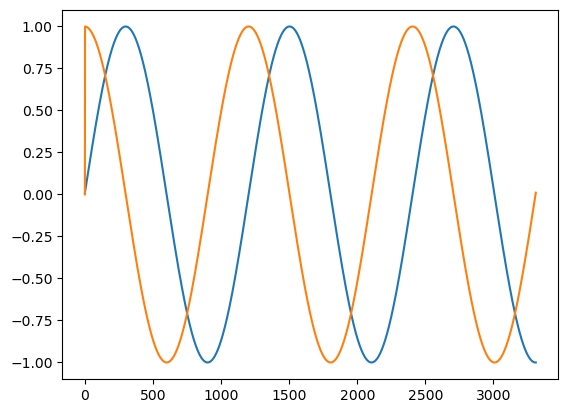

In [110]:
def create_synthetic_data(d, n, ifnoise=False):
    res = np.zeros((d, n))
    assert isinstance(n, int), "wrong number for samples"
    der = []
    for i in range(0, n):
        freq = np.random.uniform(1.0 / d, 5 * 1.0 / d)
        phi = np.random.random()
        step = np.arange(d)
        res[:, i] = np.sin(2 * np.pi * freq * step + phi * (np.pi / 180))
        der.append(2 * np.pi * freq)

    return res, der


def create_dataset(raw_data, raw_der):
    sine_dataset = dict()
    for i, real_data in enumerate(raw_data):
        worm = "worm" + str(i)
        max_time = seq_len
        num_neurons = num_signal
        der = np.array(raw_der[i])
        der = der.reshape(der.shape[0], 1).T
        time_in_seconds = torch.tensor(np.array(np.arange(seq_len)).reshape(seq_len, 1))
        dt = torch.tensor(der)

        num_named = num_neurons
        real_data = torch.tensor(
            real_data, dtype=torch.float64
        )

        smooth_real_data, residual, smooth_residual = smooth_data_preprocess(real_data, "fft")

        for i in range(residual.shape[1]):
            residual[:, i] = residual[:, i] / dt[:, i]

        sine_dataset.update(
            {
                worm: {
                    "dataset": "sine",
                    "worm": worm,
                    "calcium_data": real_data,
                    "smooth_calcium_data": smooth_real_data,
                    "residual_calcium": residual,
                    "residual_smooth_calcium": smooth_residual,
                    "neuron_to_idx": range(0, num_neurons),
                    "idx_to_neuron": range(num_neurons - 1, -1, -1),
                    "max_time": int(max_time),
                    "time_in_seconds": time_in_seconds,
                    "dt": dt,
                    "named_neurons_mask": torch.full((num_neurons,), True),
                    "named_neuron_to_idx": range(0, num_neurons),
                    "idx_to_named_neuron": range(num_neurons - 1, -1, -1),
                    "num_neurons": int(num_neurons),
                    "num_named_neurons": num_named,
                    "num_unknown_neurons": int(num_neurons) - num_named,
                },
            }
        )
    return sine_dataset


# Creating signal
seq_len = 3312
num_signal = 302
if_noise = False
num_worms = 6
raw_data = []
raw_der = []
for j in range(num_worms):
    x, der = create_synthetic_data(seq_len, num_signal, if_noise)
    x_torch = Variable(torch.from_numpy(x), requires_grad=False)
    raw_data.append(x_torch)
    raw_der.append(der)

dataset = create_dataset(raw_data, raw_der)
print(dataset["worm0"].keys())


# dataset = get_dataset(OmegaConf.load("conf/dataset.yaml"))

plt.plot(dataset["worm0"]["calcium_data"][:, 0])
plt.plot(dataset["worm0"]["residual_calcium"][:, 0])
plt.show()
# plt.legend(["cal", "res"], loc="upper right")
# plt.show()

# config = OmegaConf.load("conf/model.yaml")
# print("Model:", OmegaConf.to_yaml(config), end="\n\n")
# model = get_model(config)
#
# config = OmegaConf.load("conf/train.yaml")
# model, log_dir = train_model(model, dataset, config)

## DataLoader

In [111]:
worm_train = []
worm_test = []
worm = "worm0"
cutdown = 3312
cutneuron = 10
calcium_data = dataset[worm]["calcium_data"][:cutdown, :cutneuron].float()
residual_calcium = dataset[worm]["residual_calcium"][:cutdown, :cutneuron].float()

# train and test
train_size = int(0.8 * cutdown)
test_size = cutdown - train_size

train_ca, test_ca = calcium_data.split(train_size, dim=0)
train_res, test_res = residual_calcium.split(train_size, dim=0)

print(train_ca.shape)

torch.Size([2649, 10])


In [112]:
train_loop_cal = []
train_loop_res = []
for i in range(0, train_ca.shape[0] - time_step):
    train_loop_res.append(np.array(train_res[i:i + time_step, :]))
    train_loop_cal.append(np.array(train_ca[i:i + time_step, :]))

train_loop_cal = torch.tensor(np.array(train_loop_cal))
train_loop_res = torch.tensor(np.array(train_loop_res))

# print(train_loop_cal.shape, train_loop_res.shape)

test_loop_cal = []
test_loop_res = []
for i in range(0, test_ca.shape[0] - time_step):
    test_loop_res.append(np.array(test_res[i:i + time_step, :]))
    test_loop_cal.append(np.array(test_ca[i:i + time_step, :]))

test_loop_cal = torch.tensor(np.array(test_loop_cal))
test_loop_res = torch.tensor(np.array(test_loop_res))


In [113]:
print(train_loop_cal.shape)

torch.Size([2646, 3, 10])


In [114]:
train_loop_cal_target = torch.zeros_like(train_loop_cal)
train_loop_cal_target[:-1] = train_loop_cal[1:]

test_loop_cal_target = torch.zeros_like(test_loop_cal)
test_loop_cal_target[:-1] = test_loop_cal[1:]


train_dataset = Data.TensorDataset(train_loop_cal, train_loop_cal_target)
test_dataset = Data.TensorDataset(test_loop_cal, test_loop_cal_target)


train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [115]:
model = lstm(INPUT_SIZE, HIDDEN_SIZE, LAYERS, DROP_RATE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss(reduction="mean")
print(model)

lstm(
  (rnn): LSTM(3, 100, num_layers=2, batch_first=True)
  (hidden_out): Linear(in_features=100, out_features=3, bias=True)
)


Start Training!
--------worm No. 0--------


/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_9251/4210822571.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_9251/4210822571.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)


epoch = 0, train_loss = -0.0021, test_loss = -0.0001
epoch = 1, train_loss = -0.0094, test_loss = 0.0002
epoch = 2, train_loss = -0.0130, test_loss = -0.0012
epoch = 3, train_loss = -0.0176, test_loss = -0.0049
epoch = 4, train_loss = -0.0240, test_loss = -0.0089
epoch = 5, train_loss = -0.0327, test_loss = -0.0145
epoch = 6, train_loss = -0.0458, test_loss = -0.0228
epoch = 7, train_loss = -0.0647, test_loss = -0.0346
epoch = 8, train_loss = -0.0907, test_loss = -0.0509
epoch = 9, train_loss = -0.1225, test_loss = -0.0722
epoch = 10, train_loss = -0.1543, test_loss = -0.0940
epoch = 11, train_loss = -0.1804, test_loss = -0.1177
epoch = 12, train_loss = -0.2027, test_loss = -0.1421
epoch = 13, train_loss = -0.2236, test_loss = -0.1679
epoch = 14, train_loss = -0.2470, test_loss = -0.1944
epoch = 15, train_loss = -0.2711, test_loss = -0.2288
epoch = 16, train_loss = -0.2983, test_loss = -0.2663
epoch = 17, train_loss = -0.3268, test_loss = -0.3058
epoch = 18, train_loss = -0.3554, test_

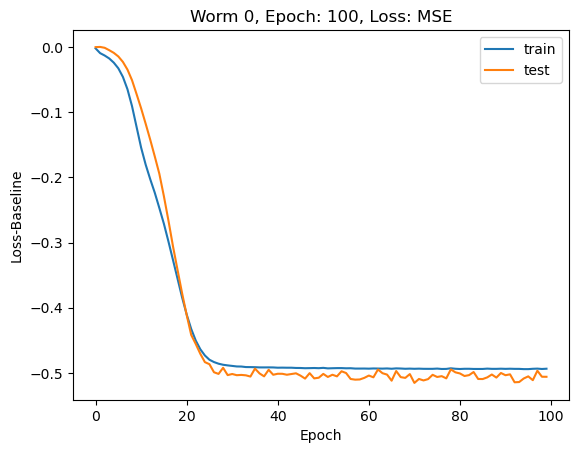

In [116]:
print("Start Training!")
# train
for i in range(len(dataset) - 5):
    print("--------worm " + "No. " + str(i) + "--------")
    # train_loader = worm_train[i]
    # test_loader = worm_test[i]
    train_base_loss_history = []
    train_pred_loss_history = []
    test_base_loss_history = []
    test_pred_loss_history = []
    for e in range(EPOCH):
        train_base_loss = 0
        train_pred_loss = 0
        test_base_loss = 0
        test_pred_loss = 0
        count = 0
        for X_train, Y_train in train_loader:
            X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
            optimizer.zero_grad()
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_train), Y_train)
            Y_tr = model(X_train.transpose(1, 2))  # Forward pass.
            Y_tr = Y_tr.transpose(1, 2)
            loss = criterion(Y_tr, Y_train)
            loss.backward(retain_graph=True)
            optimizer.step()  # Update parameters based on gradients.
            train_base_loss += base.detach().item()
            train_pred_loss += loss.detach().item()
            count += 1
        train_base_loss_history.append(train_base_loss / count)
        train_pred_loss_history.append(train_pred_loss / count)
        count = 0
        for X_test, Y_test in test_loader:
            X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)
            optimizer.zero_grad()  # Clear gradients.
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_test), Y_test)
            # X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
            Y_pred = model(X_test.transpose(1, 2))  # Forward pass.
            Y_pred = Y_pred.transpose(1, 2)
            loss = criterion(Y_pred, Y_test)
            test_base_loss += base.detach().item()
            test_pred_loss += loss.detach().item()
            count += 1
        test_base_loss_history.append(test_base_loss / count)
        test_pred_loss_history.append(test_pred_loss / count)

        print("epoch = {}, train_loss = {:.4f}, test_loss = {:.4f}".format(e,train_pred_loss_history[-1]-train_base_loss_history[-1],test_pred_loss_history[-1]-test_base_loss_history[-1]))

    delta_train = [train_pred_loss_history[i] - train_base_loss_history[i] for i in range(len(train_base_loss_history))]
    delta_test = [test_pred_loss_history[i] - test_base_loss_history[i] for i in range(len(test_base_loss_history))]
    plt.plot(delta_train)
    plt.plot(delta_test)
    plt.legend(["train", "test"])
    plt.ylabel("Loss-Baseline")
    plt.xlabel("Epoch")
    plt.title("Worm " + str(i) + ", Epoch: " + str(EPOCH) + ", Loss: MSE")
    plt.show()

In [117]:
print(INPUT_SIZE, HIDDEN_SIZE)
print(time_step)

3 100
3


torch.Size([3308, 3, 10])
torch.Size([3308, 3, 10]) torch.Size([3308, 3, 10])


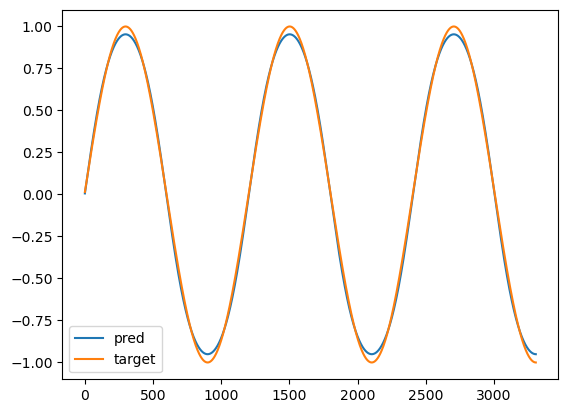

In [118]:
# visualization of prediction
pred = []
target = []
X_test = []
Y_test = []

for i in range(time_step, calcium_data.shape[0]-1):
    X, Y = calcium_data[i-time_step:i, :], calcium_data[i-time_step+1:i+1, :]
    X_test.append(np.array(X))
    Y_test.append(np.array(Y))

X_test = torch.tensor(np.array(X_test))
Y_test = torch.tensor(np.array(Y_test))
print(X_test.shape)
optimizer.zero_grad()  # Clear gradients.
# Baseline: loss if the model predicted the residual to be 0
base = criterion(torch.zeros_like(Y_test), Y_test)
# X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
Y_pred = model(X_test.transpose(1, 2))  # Forward pass.
Y_pred = Y_pred.transpose(1, 2)
print(Y_pred.shape, Y_test.shape)

# [batch, time_step, neuron]
plt.plot(Y_pred.detach().numpy()[:, 0, 0])
plt.plot(Y_test.detach().numpy()[:, 0, 0])
plt.legend(["pred", "target"])
plt.show()